In [3]:
# imports
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import datetime as dt

In [1]:
import sys
# custom imports
sys.path.append('../src')
# test function import
from fetch_range_data import fetch_range_data

# Bitcoin

The purpsose of this notebook is to explore methods of bitcoin price forecasting

## Get today's data

In [5]:
#  function to get data
today = dt.date.today()
fetch_range_data('BTC/USD', '2015/08/20', today)

## Import Data

### Explore special values for BTC

In [5]:
#create df for up-to-date btc from api data (saved locally)
btc = pd.read_csv('../data/daily_combined/combined_coinbase_2021-07-28', index_col='Unnamed: 0')
btc.pop('index')
# rename to match kaggle btc dataframe
my_dict = {'date': 'Date', 'open': 'Open', 'close': 'Close', 'high': 'High', 'low': 'Low', 'volume':'Volume', 'vol_fiat':'Market Cap'}
btc.rename(columns=my_dict, inplace=True)

print(btc.shape, btc.shape)


FileNotFoundError: [Errno 2] File ../data/combined_coinbase_2021-07-28 does not exist: '../data/combined_coinbase_2021-07-28'

### Convert Index to Datetime

In [ ]:
# change btc index to Date column datetime objects
btc.set_index(pd.to_datetime(btc['Date']),inplace=True)
btc = btc.drop(['Date', 'unix'],axis=1)

In [6]:
# btc.set_index('Date')
# sort indicies for ease of comparison
btc.sort_index(inplace=True)
btc

NameError: name 'btc_new' is not defined

In [8]:
type(btc.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [9]:
btc.columns

Index(['Low', 'High', 'Open', 'Close', 'Volume', 'Market Cap'], dtype='object')

In [10]:
btc.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap'], dtype='object')

In [11]:
btc

,Low,High,Open,Close,Volume,Market Cap
Date,,,,,,
2015-07-20,277.37,280.00,277.98,280.00,782.883420,2.192074e+05
2015-07-21,276.85,281.27,279.96,277.32,4943.559434,1.370948e+06
2015-07-22,275.01,278.54,277.33,277.89,4687.909383,1.302723e+06
2015-07-23,276.28,279.75,277.96,277.39,5306.919575,1.472086e+06
2015-07-24,276.43,291.52,277.23,289.12,7362.469083,2.128637e+06
...,...,...,...,...,...,...
2021-07-24,33424.70,34525.00,33647.27,34283.01,9864.752437,3.381934e+08
2021-07-25,33888.89,35451.04,34291.67,35428.26,9434.630023,3.342525e+08
2021-07-26,35251.54,40593.93,35428.25,37262.77,40354.545558,1.503722e+09


In [12]:
btc

,Low,High,Open,Close,Volume,Market Cap
Date,,,,,,
2015-07-20,277.37,280.00,277.98,280.00,782.883420,2.192074e+05
2015-07-21,276.85,281.27,279.96,277.32,4943.559434,1.370948e+06
2015-07-22,275.01,278.54,277.33,277.89,4687.909383,1.302723e+06
2015-07-23,276.28,279.75,277.96,277.39,5306.919575,1.472086e+06
2015-07-24,276.43,291.52,277.23,289.12,7362.469083,2.128637e+06
...,...,...,...,...,...,...
2021-07-24,33424.70,34525.00,33647.27,34283.01,9864.752437,3.381934e+08
2021-07-25,33888.89,35451.04,34291.67,35428.26,9434.630023,3.342525e+08
2021-07-26,35251.54,40593.93,35428.25,37262.77,40354.545558,1.503722e+09


In [13]:
btcM = btc.resample('M').mean()
btcM

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-04-30,137.913333,143.466667,133.383333,139.250000,NaN,1.529820e+09
2013-05-31,120.292258,123.948710,114.253226,119.992581,NaN,1.342523e+09
2013-06-30,108.856667,111.300667,104.602000,107.761333,NaN,1.228664e+09
2013-07-31,90.311290,93.869032,86.719677,90.512258,NaN,1.031498e+09
2013-08-31,113.041935,116.002258,111.387742,113.905161,NaN,1.306910e+09
...,...,...,...,...,...,...
2018-05-31,8505.240645,8638.820000,8283.560645,8450.997742,6.374571e+09,1.448831e+11
2018-06-30,6829.258000,6930.069000,6670.762667,6793.507667,4.340473e+09,1.167378e+11
2018-07-31,7101.466452,7258.952581,6982.127419,7146.350000,4.562643e+09,1.218138e+11


In [14]:
btcD = btcM.resample('D').mean()
btcD

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-04-30,137.913333,143.466667,133.383333,139.250000,NaN,1.529820e+09
2013-05-01,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-02,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-03,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-04,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2018-09-26,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-27,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-28,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Bitcoin Price over Time')

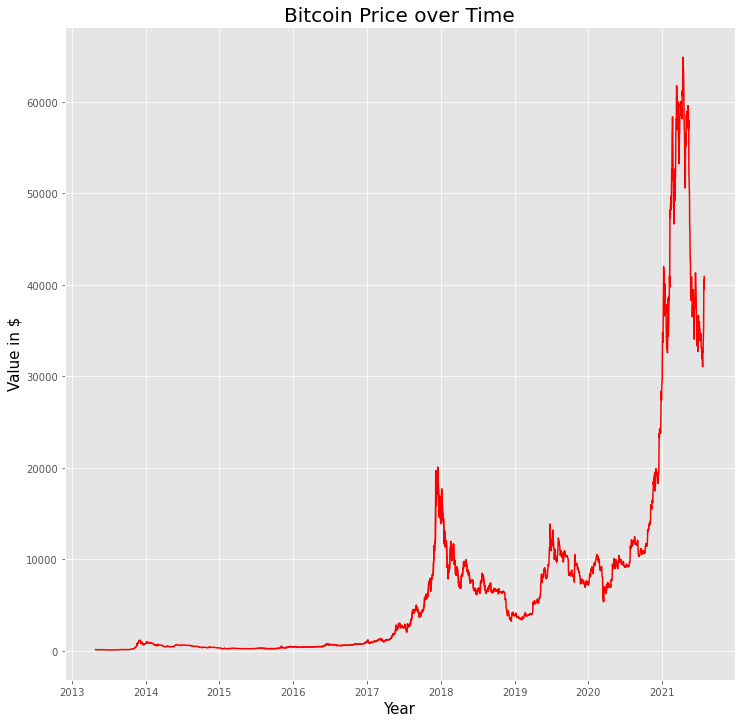

In [15]:
plt.style.use('ggplot')
figsize = (12,12)
fig, ax = plt.subplots(figsize=figsize)
ax.plot(btc.index, btc.High, c='r', lw=1.5)
ax.plot(btc.index, btc.High, c='r', lw=1.5)
ax.set_xlabel("Year", fontsize=15, color='black')
ax.set_ylabel('Value in $', fontsize=15, color='black')
ax.set_title('Bitcoin Price over Time', fontsize=20, color='black')
# plt.savefig('bitcoin_historical_transparent.png', transparent=True, dpi=400)
# plt.savefig('bitcoin_historical.png', transparent=False, dpi=400)

Text(0.5, 1.0, 'Bitcoin Daily Closing Price')

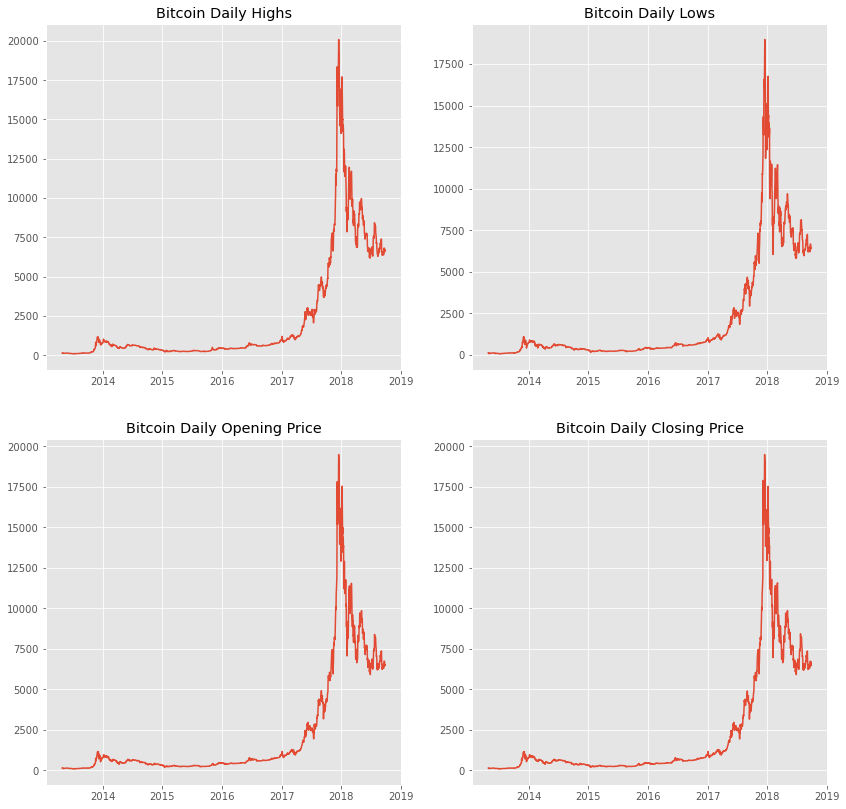

In [16]:
m = 2
n = 2
figsize = (14,14)
fig, ax = plt.subplots(nrows=m, ncols=n, figsize=figsize)

ax[0,0].plot(btc.index, btc.High)
ax[0,1].plot(btc.index, btc.Low)
ax[1,0].plot(btc.index, btc.Open)
ax[1,1].plot(btc.index, btc.Close)

ax[0,0].set_title('Bitcoin Daily Highs')
ax[0,1].set_title('Bitcoin Daily Lows')
ax[1,0].set_title('Bitcoin Daily Opening Price')
ax[1,1].set_title('Bitcoin Daily Closing Price')

Text(0.5, 1.0, 'Bitcoin Daily Closing')

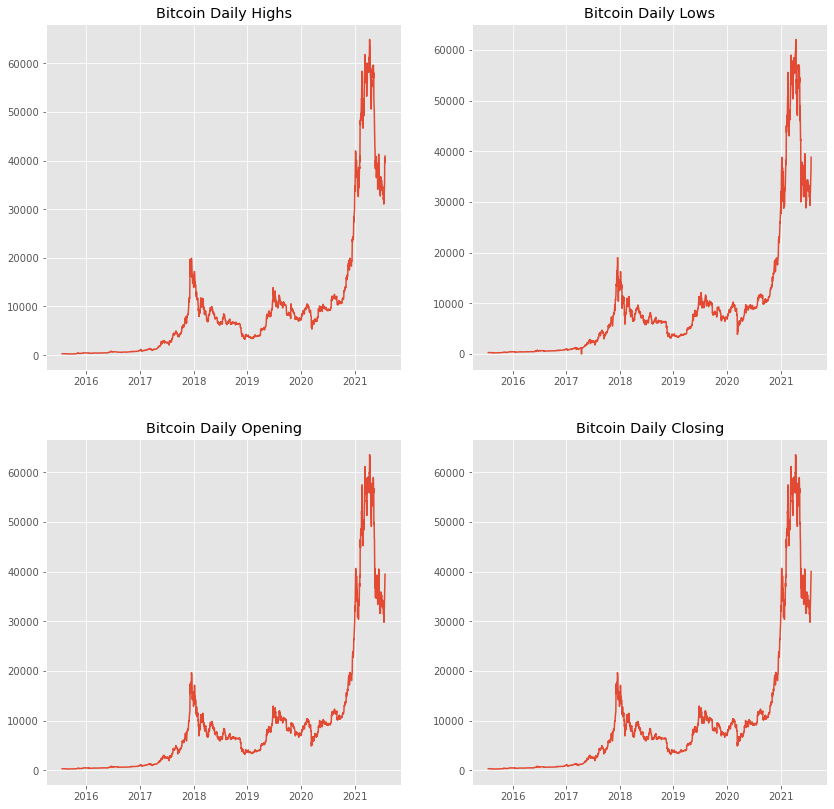

In [17]:
m = 2
n = 2
figsize = (14,14)
fig, ax = plt.subplots(nrows=m, ncols=n, figsize=figsize)

ax[0,0].plot(btc.index, btc.High)
ax[0,1].plot(btc.index, btc.Low)
ax[1,0].plot(btc.index, btc.Open)
ax[1,1].plot(btc.index, btc.Close)

ax[0,0].set_title('Bitcoin Daily Highs')
ax[0,1].set_title('Bitcoin Daily Lows')
ax[1,0].set_title('Bitcoin Daily Opening')
ax[1,1].set_title('Bitcoin Daily Closing')

# First Simple Model - Random Walk

In [18]:
end_of_train_index = int(btc.shape[0]*0.8)
end_of_train_index

1583

In [19]:
train = btc.Close[:end_of_train_index]
test = btc.Close[end_of_train_index:]

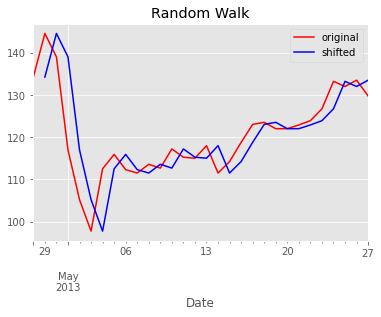

In [20]:
random_walk = train.shift(1)

fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
random_walk[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('Random Walk')
ax.legend();

In [21]:
random_walk.dropna(inplace=True)

In [22]:
import sklearn.metrics as metric

In [23]:
train.shape[0]

1583

In [24]:
random_walk[:3]

Date
2013-04-29    134.21
2013-04-30    144.54
2013-05-01    139.00
Name: Close, dtype: float64

In [25]:
train[:3]

Date
2013-04-28    134.21
2013-04-29    144.54
2013-04-30    139.00
Name: Close, dtype: float64

In [26]:
train.index

DatetimeIndex(['2013-04-28', '2013-04-29', '2013-04-30', '2013-05-01',
               '2013-05-02', '2013-05-03', '2013-05-04', '2013-05-05',
               '2013-05-06', '2013-05-07',
               ...
               '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21',
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27'],
              dtype='datetime64[ns]', name='Date', length=1583, freq=None)

In [27]:
random_walk.index

DatetimeIndex(['2013-04-29', '2013-04-30', '2013-05-01', '2013-05-02',
               '2013-05-03', '2013-05-04', '2013-05-05', '2013-05-06',
               '2013-05-07', '2013-05-08',
               ...
               '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21',
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27'],
              dtype='datetime64[ns]', name='Date', length=1582, freq=None)

In [28]:
metric.mean_squared_error(train[1:], random_walk)

1736.6420481036666

In [29]:
metric.mean_squared_log_error(train['2013-04-30':'2013-05-30'], random_walk['2013-04-30':'2013-05-30'])

0.0026870567160339398

## ARIMA MODEL

In [30]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

In [31]:
# create timeseriessplit object
data = btc.Close
tss = TimeSeriesSplit(n_splits = 5)
tss.split(data)

<generator object TimeSeriesSplit.split at 0x000001BD3BE29970>

In [32]:
data

Date
2013-04-28     134.21
2013-04-29     144.54
2013-04-30     139.00
2013-05-01     116.99
2013-05-02     105.21
               ...   
2018-09-23    6710.63
2018-09-24    6595.41
2018-09-25    6446.47
2018-09-26    6495.00
2018-09-27    6676.75
Name: Close, Length: 1979, dtype: float64

In [33]:
# define function to print min and max of array/list
def print_info(input_):
    min_value = min(input_) 
    max_value = max(input_)
    
    return f'min: {min_value} max: {max_value}\n'

In [34]:
# iterate thgouh timeseriessplit object and print info
for train_index, test_index in tss.split(data):
    print('Train:', print_info(train_index))
    print('Test:', print_info(test_index))

Train: min: 0 max: 333

Test: min: 334 max: 662

Train: min: 0 max: 662

Test: min: 663 max: 991

Train: min: 0 max: 991

Test: min: 992 max: 1320

Train: min: 0 max: 1320

Test: min: 1321 max: 1649

Train: min: 0 max: 1649

Test: min: 1650 max: 1978



In [35]:
try:
    i=1
    while True:
        print(globals()[f'i{i}'])
        i+=1
except:
    print('Done')

Done


In [36]:
test_index[1]

1651

In [37]:
x = btc['Close'].iloc[train_index[0]]
x
# x.append(btc['Close'].iloc[train_index[1]])
# x

134.21

In [38]:
# CREATE arima_model object, pass training set and order

# (0,1,0) as the order means 1st order differenced model, essentially a random walk

rw = ARIMA(train, (0,1,0), freq='D').fit()

y_hat = rw.predict(typ='levels')
y_hat

2013-04-29     136.895632
2013-04-30     147.225632
2013-05-01     141.685632
2013-05-02     119.675632
2013-05-03     107.895632
                 ...     
2017-08-23    4103.205632
2017-08-24    4154.205632
2017-08-25    4337.365632
2017-08-26    4374.285632
2017-08-27    4355.085632
Freq: D, Length: 1582, dtype: float64

In [39]:
# find squared error and compare to random walk model generated manually
metric.mean_squared_error(train[1:], y_hat)

1729.429428266681

In [40]:
# per answer above, essentially random walk model

In [41]:
# CREATE arima_model object, pass training set and order

# (1,1,0) as the order means 1st order differenced model, with additional lag

ar_1 = ARIMA(train, (1,1,0), freq='D').fit()

y_hat = ar_1.predict(typ='levels')
y_hat

2013-04-29     136.896156
2013-04-30     147.409508
2013-05-01     141.488836
2013-05-02     119.083772
2013-05-03     107.549158
                 ...     
2017-08-23    4105.511149
2017-08-24    4155.365055
2017-08-25    4341.695164
2017-08-26    4375.107320
2017-08-27    4354.561175
Freq: D, Length: 1582, dtype: float64

In [42]:
metric.mean_squared_error(train[1:], y_hat)

1728.433415133815

In [43]:
# CREATE arima_model object, pass training set and order

# try higher order models

ar_2 = ARIMA(train, (1,2,1), freq='D').fit()

y_hat = ar_2.predict(typ='levels')
y_hat

2013-04-30     154.885044
2013-05-01     141.386915
2013-05-02     111.216079
2013-05-03      97.990709
2013-05-04      90.514020
                 ...     
2017-08-23    4121.901447
2017-08-24    4173.047590
2017-08-25    4358.432240
2017-08-26    4394.950258
2017-08-27    4375.102446
Freq: D, Length: 1581, dtype: float64

In [44]:
metric.mean_squared_error(train[2:], y_hat)

1712.4775402782118

In [45]:
ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.Close   No. Observations:                 1581
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -8130.940
Method:                       css-mle   S.D. of innovations             41.378
Date:                Thu, 12 Aug 2021   AIC                          16269.879
Time:                        22:40:15   BIC                          16291.343
Sample:                    04-30-2013   HQIC                         16277.854
                         - 08-27-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0150      0.012      1.242      0.214      -0.009       0.039
ar.L1.D2.Close     0.0038      0.025      0.149      0.881      -0.046       0.054
ma.L1.D2.Close    -0.9894      0.004   -230.480      0.000      -0.998      -0.981
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          262.9998           +0.0000j          262.9998            0.0000
MA.1            1.0107           +0.0000j            1.0107            0.0000
-----------------------------------------------------------------------------
"""

In [46]:
# additoinal ARIMIA model
ar_3 = ARIMA(train, (4,2,3), freq='D').fit()

y_hat = ar_3.predict(typ='levels')
y_hat

C:\Users\samjd\anaconda3\envs\oy-env\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


2013-04-30     154.890070
2013-05-01     143.699310
2013-05-02     132.095900
2013-05-03      89.875237
2013-05-04      83.916587
                 ...     
2017-08-23    4061.811764
2017-08-24    4199.758310
2017-08-25    4398.331510
2017-08-26    4337.701088
2017-08-27    4426.505509
Freq: D, Length: 1581, dtype: float64

In [47]:
metric.mean_squared_error(train[2:], y_hat)

1635.6810187215967

In [48]:
# additoinal ARIMIA model
ar_4 = ARIMA(train, (1,1,4), freq='D').fit()

y_hat = ar_4.predict(typ='levels')
metric.mean_squared_error(train[1:], y_hat)

1722.6314650319014

In [49]:
TimeSeriesSplit(5, btc['Close'], max_train_size=0.8*btc.shape[0])

C:\Users\samjd\anaconda3\envs\oy-env\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass max_train_size=Date
2013-04-28     134.21
2013-04-29     144.54
2013-04-30     139.00
2013-05-01     116.99
2013-05-02     105.21
               ...   
2018-09-23    6710.63
2018-09-24    6595.41
2018-09-25    6446.47
2018-09-26    6495.00
2018-09-27    6676.75
Name: Close, Length: 1979, dtype: float64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


TimeSeriesSplit(max_train_size=Date
2013-04-28     134.21
2013-04-29     144.54
2013-04-30     139.00
2013-05-01     116.99
2013-05-02     105.21
               ...
2018-09-23    6710.63
2018-09-24    6595.41
2018-09-25    6446.47
2018-09-26    6495.00
2018-09-27    6676.75
Name: Close, Length: 1979, dtype: float64,
        n_splits=5)

### Make function to make data reshaping easier

In [154]:
# function converts data to array and reshapes for linreg compatibility 
def arr_shape(data):
    data = np.array(data)
    data = data.reshape(-1,1)
    return data

## Linear Regression

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [70]:
btc.shape

(2201, 6)

In [68]:
btc.Close

Date
2015-07-20      280.00
2015-07-21      277.32
2015-07-22      277.89
2015-07-23      277.39
2015-07-24      289.12
                ...   
2021-07-24    34283.01
2021-07-25    35428.26
2021-07-26    37262.77
2021-07-27    39470.48
2021-07-28    40035.10
Name: Close, Length: 2201, dtype: float64

In [139]:
close = btc.Close
close.reset_index(drop=True, inplace=True)
close_index = close.index
close = np.squeeze(close.to_numpy())
close_index = np.squeeze(close_index.to_numpy())

In [153]:
close_index[0]

0

In [155]:
# # separate data for linear regression
X_train, X_test, y_train, y_test = train_test_split(close_index, close)

# reshape for linreg
X_train = arr_shape(X_train)
X_test = arr_shape(X_test)
y_train = arr_shape(y_train)
y_test = arr_shape(y_test)


In [156]:
y_train

array([[ 2786.07],
       [ 4214.84],
       [  238.34],
       ...,
       [ 6928.5 ],
       [ 1292.86],
       [50089.15]])

In [157]:
X_train

array([[ 739],
       [ 807],
       [  73],
       ...,
       [ 985],
       [ 592],
       [2105]], dtype=int64)

In [158]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [159]:
preds = lr.predict(X_test)

In [160]:
lr.intercept_

array([-5766.96796992])

In [163]:
lr.coef_

array([[13.56697558]])